In [8]:
# Imports
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from torch.utils.data import DataLoader
from tqdm import tqdm
import yaml
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.data_prep import DataPreprocessor, BreastThermographyDataset
from src.model import HybridCNNViT, ModelBuilder

In [9]:
class ModelEvaluator:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.model.eval()
        
    def evaluate(self, dataloader):
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating"):
                try:
                    # Handle different batch formats
                    if isinstance(batch, dict):
                        images = batch['image']
                        labels = batch['label']
                    elif isinstance(batch, (list, tuple)) and len(batch) >= 2:
                        images, labels = batch[0], batch[1]
                    else:
                        print(f"Skipping unexpected batch type: {type(batch)}")
                        continue
                    
                    # Move to device
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Forward pass
                    outputs = self.model(images)
                    
                    # Handle different model output formats
                    if isinstance(outputs, dict):
                        # Try different possible output keys
                        output_keys = ['logits', 'output', 'out', 'prediction']
                        for key in output_keys:
                            if key in outputs:
                                outputs = outputs[key]
                                break
                        else:
                            # If no matching key, try to get the first tensor value
                            for value in outputs.values():
                                if torch.is_tensor(value):
                                    outputs = value
                                    break
                            else:
                                print("Could not extract tensor from model outputs")
                                continue
                    
                    # Ensure outputs is a tensor
                    if not torch.is_tensor(outputs):
                        print(f"Unexpected output type: {type(outputs)}")
                        continue
                    
                    # Get predictions and probabilities
                    probs = torch.softmax(outputs, dim=1)
                    _, preds = torch.max(outputs, 1)
                    
                    # Store results
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
                    
                except Exception as e:
                    print(f"Error processing batch: {str(e)}")
                    import traceback
                    traceback.print_exc()
                    continue
        
        if not all_preds:
            raise ValueError("No valid batches were processed. Check your data loading pipeline.")
        
        return np.array(all_preds), np.array(all_labels), np.array(all_probs)

    def plot_confusion_matrix(self, y_true, y_pred, class_names=None):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names or ['Benign', 'Malignant'],
                   yticklabels=class_names or ['Benign', 'Malignant'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_roc_curve(self, y_true, y_probs, class_names=None):
        """Plot ROC curve"""
        if y_probs.shape[1] == 1:  # binary classification
            fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()
        else:
            # Multi-class ROC
            n_classes = y_probs.shape[1]
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            plt.figure(figsize=(8, 6))
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i], lw=2,
                        label=f'Class {class_names[i] if class_names else i} (area = {roc_auc[i]:.2f})')
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

    def plot_precision_recall_curve(self, y_true, y_probs, class_names=None):
        """Plot precision-recall curve"""
        if y_probs.shape[1] == 1:  # binary classification
            precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1])
            avg_precision = average_precision_score(y_true, y_probs[:, 1])
            
            plt.figure(figsize=(8, 6))
            plt.step(recall, precision, where='post')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title(f'Precision-Recall curve (AP = {avg_precision:0.2f})')
            plt.show()
        else:
            # Multi-class precision-recall
            n_classes = y_probs.shape[1]
            precision = dict()
            recall = dict()
            avg_precision = dict()
            
            for i in range(n_classes):
                precision[i], recall[i], _ = precision_recall_curve((y_true == i).astype(int), y_probs[:, i])
                avg_precision[i] = average_precision_score((y_true == i).astype(int), y_probs[:, i])
            
            plt.figure(figsize=(8, 6))
            for i in range(n_classes):
                plt.step(recall[i], precision[i], where='post',
                        label=f'Class {class_names[i] if class_names else i} (AP = {avg_precision[i]:0.2f})')
            
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title('Precision-Recall curve')
            plt.legend(loc="lower left")
            plt.show()

In [10]:
def check_data_loading(dataloader, num_batches=2):
    """Helper function to verify data loading"""
    print("\n" + "="*60)
    print("Checking Data Loading...")
    print("="*60)
    
    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break
            
        print(f"\nBatch {i+1}:")
        
        # Handle different batch formats
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            # If batch is a tuple/list of (images, labels)
            images, labels = batch[0], batch[1]
            print(f"Images shape: {images.shape}")
            print(f"Image range: {images.min():.2f} to {images.max():.2f}")
            print(f"Labels: {labels}")
        elif isinstance(batch, dict):
            # If batch is a dictionary
            if 'image' in batch and 'label' in batch:
                print(f"Images shape: {batch['image'].shape}")
                print(f"Image range: {batch['image'].min():.2f} to {batch['image'].max():.2f}")
                print(f"Labels: {batch['label']}")
            else:
                print("Unexpected batch format. Available keys:", batch.keys())
        else:
            print(f"Unexpected batch type: {type(batch)}")

In [11]:
def get_project_root():
    """Get the project root directory in a way that works in both scripts and notebooks"""
    try:
        # This works in regular Python files
        return os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    except NameError:
        project_root = os.getcwd()
        while project_root != '/':
            if os.path.exists(os.path.join(project_root, 'configs', 'config.yaml')):
                return project_root
            project_root = os.path.dirname(project_root)
        raise FileNotFoundError("Could not find project root directory")

In [12]:
def inspect_dataloader(dataloader, num_batches=2):
    """Inspect the structure of the dataloader output"""
    print("\n" + "="*60)
    print("Inspecting DataLoader Output")
    print("="*60)
    
    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break
            
        print(f"\nBatch {i+1}:")
        print(f"Type: {type(batch)}")
        
        if isinstance(batch, dict):
            print("Dictionary keys:", batch.keys())
            for key, value in batch.items():
                print(f"  {key}: {type(value)}")
                if isinstance(value, torch.Tensor):
                    print(f"    Shape: {value.shape}")
                    print(f"    Dtype: {value.dtype}")
                    print(f"    Min: {value.min().item()}")
                    print(f"    Max: {value.max().item()}")
                elif isinstance(value, (list, tuple)):
                    print(f"    Length: {len(value)}")
                    if value:
                        print(f"    First item type: {type(value[0])}")
                else:
                    print(f"    Value: {value}")
        
        elif isinstance(batch, (list, tuple)):
            print(f"Length: {len(batch)}")
            for j, item in enumerate(batch):
                print(f"  Item {j}: Type={type(item)}")
                if isinstance(item, torch.Tensor):
                    print(f"    Shape: {item.shape}")
                    print(f"    Dtype: {item.dtype}")
        
        print("\n" + "-"*60)

In [13]:
def run_evaluation(model_path=None, test_loader=None):
    """Run full evaluation pipeline"""
    # Create model using the ModelBuilder with the correct config path
    config_path = os.path.join(get_project_root(), 'configs', 'config.yaml')
    
    # Load config to get data paths
    with open(config_path) as f:
        config = yaml.safe_load(f)
    
    # Initialize model
    builder = ModelBuilder(config_path=config_path)
    model = builder.build_model()
    
    # Load the best model weights
    if model_path is None:
        model_path = os.path.join(get_project_root(), 'notebooks', 'outputs', 'models', 'best_model.pth')
    
    print(f"Loading model from: {model_path}")
    checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
    
    # Handle different checkpoint formats
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    elif 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        # Direct model weights
        model.load_state_dict(checkpoint)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Initialize data preprocessor
    preprocessor = DataPreprocessor(config_path=config_path)
    
    # If test_loader is not provided, create one
    if test_loader is None:
        # Create datasets
        _, _, test_df = preprocessor.create_datasets(save_processed=False)
        
        # Create test dataset with validation transforms
        test_transform = preprocessor.create_transforms(is_train=False)
        test_dataset = BreastThermographyDataset(
            test_df,
            transform=test_transform,
            config=config,
            data_preprocessor=preprocessor
        )
        
        # Create test loader
        test_loader = DataLoader(
            test_dataset,
            batch_size=config['training']['batch_size'],
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
    
    # Initialize evaluator
    evaluator = ModelEvaluator(model, device)
    
    try:
        # Inspect the first few batches
        inspect_dataloader(test_loader, num_batches=2)
        
        # Run evaluation
        print("\nEvaluating model...")
        preds, labels, probs = evaluator.evaluate(test_loader)
        
        # Generate reports
        print("\nGenerating evaluation reports...")
        evaluator.plot_confusion_matrix(labels, preds)
        evaluator.plot_roc_curve(labels, probs)
        evaluator.plot_precision_recall_curve(labels, probs)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(labels, preds, target_names=['Benign', 'Malignant']))
        
        return {
            'predictions': preds,
            'labels': labels,
            'probabilities': probs
        }
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        raise

Loading model from: /mnt/d/ML/Projects/Breast-Thermography/notebooks/outputs/models/best_model.pth
Loading diagnostics from: /mnt/d/ML/Projects/Breast-Thermography/data/raw/Breast-Thermography-Raw/Diagnostics.xlsx

Inspecting DataLoader Output


/mnt/d/ML/Projects/Breast-Thermography/venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/mnt/d/ML/Projects/Breast-Thermography/src/data_prep.py:426: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0 * strength, 50.0 * strength), p=0.1 * strength),
/mnt/d/ML/Projects/Breast-Thermography/src/data_prep.py:430: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(



Batch 1:
Type: <class 'dict'>
Dictionary keys: dict_keys(['image', 'label', 'patient_id', 'temp'])
  image: <class 'torch.Tensor'>
    Shape: torch.Size([4, 9, 224, 224])
    Dtype: torch.float32
    Min: -0.008305505849421024
    Max: 0.010352940298616886
  label: <class 'torch.Tensor'>
    Shape: torch.Size([4])
    Dtype: torch.int64
    Min: 0
    Max: 0
  patient_id: <class 'list'>
    Length: 4
    First item type: <class 'str'>
  temp: <class 'torch.Tensor'>
    Shape: torch.Size([4])
    Dtype: torch.float32
    Min: 35.599998474121094
    Max: 36.599998474121094

------------------------------------------------------------

Batch 2:
Type: <class 'dict'>
Dictionary keys: dict_keys(['image', 'label', 'patient_id', 'temp'])
  image: <class 'torch.Tensor'>
    Shape: torch.Size([4, 9, 224, 224])
    Dtype: torch.float32
    Min: -0.008305505849421024
    Max: 0.010352940298616886
  label: <class 'torch.Tensor'>
    Shape: torch.Size([4])
    Dtype: torch.int64
    Min: 0
    Max:

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.05it/s]



Generating evaluation reports...


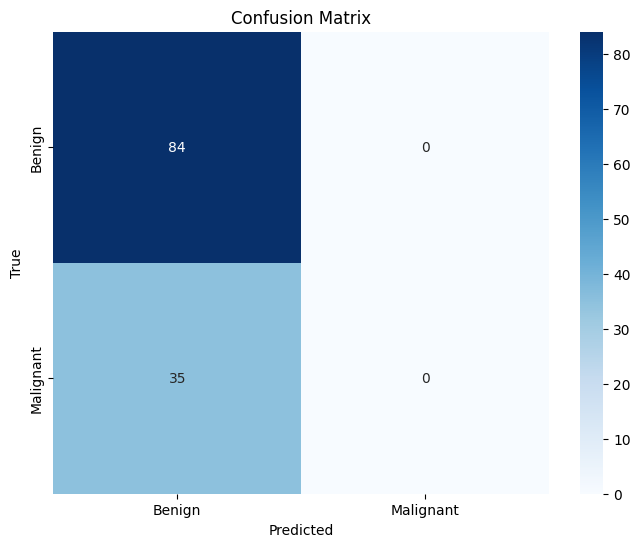

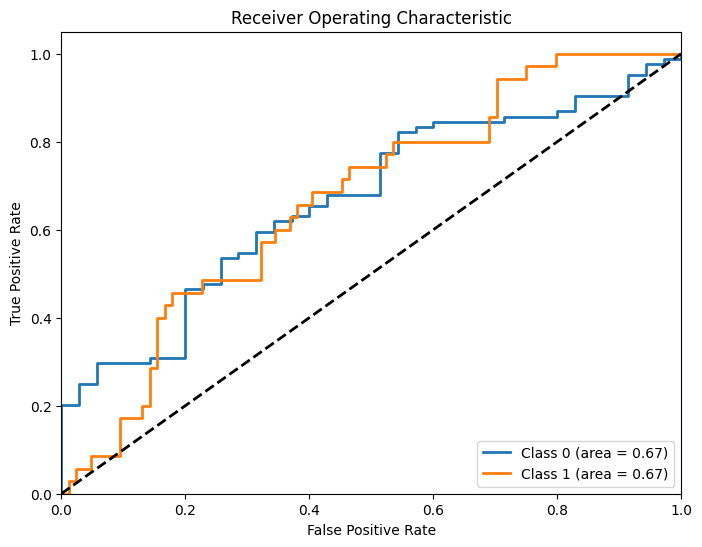

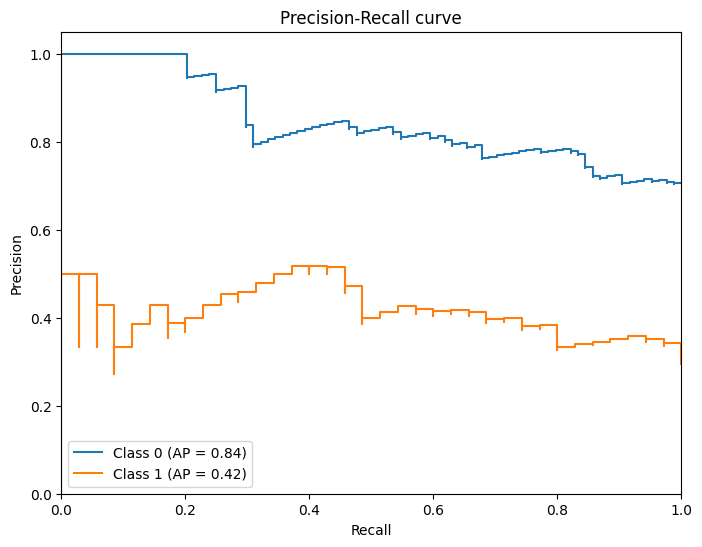


Classification Report:
              precision    recall  f1-score   support

      Benign       0.71      1.00      0.83        84
   Malignant       0.00      0.00      0.00        35

    accuracy                           0.71       119
   macro avg       0.35      0.50      0.41       119
weighted avg       0.50      0.71      0.58       119



/mnt/d/ML/Projects/Breast-Thermography/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/d/ML/Projects/Breast-Thermography/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/d/ML/Projects/Breast-Thermography/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [14]:
if __name__ == "__main__":
    try:
        # Run evaluation with best model
        results = run_evaluation()
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        raise